In [1]:
pip install "tensorflow<2.11"

  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached termcolor-2.4.0-py3-none-any.whl (7.7 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)
  Using cached tensorboard_plugin_wit-1.8.1-py3-none-any.whl (781 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Timi Durojaiye\miniconda3\envs\thesis\python.exe -m pip install --upgrade pip' command.


In [88]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

In [89]:
from ast import literal_eval

In [90]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [91]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, Conv2D, BatchNormalization, Reshape, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

### Data Processing

In [92]:
param_data = pd.read_csv("../data/svi_param_dataset.csv", converters={'moneyness': literal_eval})
param_data.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
param_data

,timestamp,Time_To_Maturity,a,b,rho,m,sigma,moneyness
0,2024-07-11 10:13:29,0.001405,5.690760e-04,0.007855,0.742280,0.066393,0.000001,"[-0.50169572997656, -0.3681643373520374, -0.25..."
1,2024-07-11 10:13:29,0.004137,4.687763e-04,0.016554,-0.535436,-0.030064,0.053354,"[-0.08526625451987675, -0.06657412150772418, -..."
2,2024-07-11 10:13:29,0.006869,1.708297e-04,0.001660,-1.000000,0.177642,1.000000,"[-0.06532972541401288, -0.046980586745816316, ..."
3,2024-07-11 10:13:29,0.020531,5.257703e-11,0.043291,0.113349,0.081359,0.097469,"[-0.4919976561918145, -0.3584662635672918, -0...."
4,2024-07-11 10:13:29,0.039656,2.218608e-15,0.065193,0.025121,0.083020,0.103800,"[-0.5171211768843152, -0.45996276304436645, -0..."
...,...,...,...,...,...,...,...,...
4467,2024-07-11 20:39:30,0.211788,4.237714e-11,0.116236,-0.419304,-0.415035,0.517738,"[-1.746148072420055, -1.3406829643118907, -1.0..."
4468,2024-07-11 20:39:30,0.460421,3.948757e-02,0.169801,-0.387733,-0.533641,0.725977,"[-1.7684504115839803, -1.3629853034758157, -1...."
4469,2024-07-11 20:39:30,0.536924,2.531792e-01,0.173018,0.354842,0.201397,0.000001,"[-1.3713221430896279, -1.0836400706378468, -0...."
4470,2024-07-11 20:39:30,0.709055,2.945203e-01,2.007008,0.993016,0.983252,0.048985,"[-1.1025201430491003, -0.8793765917348907, -0...."


In [94]:
param_data.dtypes

timestamp            object
Time_To_Maturity    float64
a                   float64
b                   float64
rho                 float64
m                   float64
sigma               float64
moneyness            object
dtype: object

Sets timestamp and time to maturity as the indexes of the dataset

In [95]:
param_data.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
param_data

a         b       rho  \
timestamp           Time_To_Maturity                                     
2024-07-11 10:13:29 0.001405          5.690760e-04  0.007855  0.742280   
                    0.004137          4.687763e-04  0.016554 -0.535436   
                    0.006869          1.708297e-04  0.001660 -1.000000   
                    0.020531          5.257703e-11  0.043291  0.113349   
                    0.039656          2.218608e-15  0.065193  0.025121   
...                                            ...       ...       ...   
2024-07-11 20:39:30 0.211788          4.237714e-11  0.116236 -0.419304   
                    0.460421          3.948757e-02  0.169801 -0.387733   
                    0.536924          2.531792e-01  0.173018  0.354842   
                    0.709055          2.945203e-01  2.007008  0.993016   
                    0.957689          4.009155e-01  0.078870  0.647930   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-07-11 10:13:29 0.001405          0.066393  0.000001   
                    0.004137         -0.030064  0.053354   
                    0.006869          0.177642  1.000000   
                    0.020531          0.081359  0.097469   
                    0.039656          0.083020  0.103800   
...                                        ...       ...   
2024-07-11 20:39:30 0.211788         -0.415035  0.517738   
                    0.460421         -0.533641  0.725977   
                    0.536924          0.201397  0.000001   
                    0.709055          0.983252  0.048985   
                    0.957689          0.290454  0.000001   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-07-11 10:13:29 0.001405          [-0.50169572997656, -0.3681643373520374, -0.25...  
                    0.004137          [-0.08526625451987675, -0.06657412150772418, -...  
                    0.006869          [-0.06532972541401288, -0.046980586745816316, ...  
                    0.020531          [-0.4919976561918145, -0.3584662635672918, -0....  
                    0.039656          [-0.5171211768843152, -0.45996276304436645, -0...  
...                                                                                 ...  
2024-07-11 20:39:30 0.211788          [-1.746148072420055, -1.3406829643118907, -1.0...  
                    0.460421          [-1.7684504115839803, -1.3629853034758157, -1....  
                    0.536924          [-1.3713221430896279, -1.0836400706378468, -0....  
                    0.709055          [-1.1025201430491003, -0.8793765917348907, -0....  
                    0.957689          [-1.1205322806079652, -0.8973887292937553, -0....  

[4472 rows x 6 columns]

In [96]:
param_data[0:13]

a         b       rho  \
timestamp           Time_To_Maturity                                     
2024-07-11 10:13:29 0.001405          5.690760e-04  0.007855  0.742280   
                    0.004137          4.687763e-04  0.016554 -0.535436   
                    0.006869          1.708297e-04  0.001660 -1.000000   
                    0.020531          5.257703e-11  0.043291  0.113349   
                    0.039656          2.218608e-15  0.065193  0.025121   
                    0.058782          4.449480e-09  0.086612 -0.011945   
                    0.077908          1.301385e-02  0.047548  0.148149   
                    0.135285          2.889907e-09  0.086860 -0.008054   
                    0.211788          2.998761e-02  0.094202 -0.366354   
                    0.460421          9.680715e-02  0.137421 -0.456437   
                    0.536924          2.332265e-01  0.327298  0.699229   
                    0.709055          2.986400e-01  0.056641  0.643676   
                    0.957689          3.718134e-01  0.137137 -0.027036   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-07-11 10:13:29 0.001405          0.066393  0.000001   
                    0.004137         -0.030064  0.053354   
                    0.006869          0.177642  1.000000   
                    0.020531          0.081359  0.097469   
                    0.039656          0.083020  0.103800   
                    0.058782          0.089083  0.134872   
                    0.077908          0.080762  0.089673   
                    0.135285          0.061702  0.347250   
                    0.211788         -0.165223  0.271514   
                    0.460421         -0.497380  0.480796   
                    0.536924          0.359000  0.088578   
                    0.709055          0.359279  0.000001   
                    0.957689          0.174850  0.000001   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-07-11 10:13:29 0.001405          [-0.50169572997656, -0.3681643373520374, -0.25...  
                    0.004137          [-0.08526625451987675, -0.06657412150772418, -...  
                    0.006869          [-0.06532972541401288, -0.046980586745816316, ...  
                    0.020531          [-0.4919976561918145, -0.3584662635672918, -0....  
                    0.039656          [-0.5171211768843152, -0.45996276304436645, -0...  
                    0.058782          [-0.6417259481641154, -0.4875752683368571, -0....  
                    0.077908          [-0.6411205647263575, -0.48696988489909915, -0...  
                    0.135285          [-0.4029375305085922, -0.3516442361210417, -0....  
                    0.211788          [-1.7356047280107758, -1.3301396199026114, -1....  
                    0.460421          [-1.7279159953780352, -1.3224508872698708, -1....  
                    0.536924          [-1.3200300850568678, -1.032348012605087, -0.8...  
                    0.709055          [-1.0270147780517862, -0.8038712267375763, -0....  
                    0.957689          [-1.0190685953550833, -0.7959250440408735, -0....

In [97]:
param_data_moneyness = param_data

In [98]:
param_data_moneyness

a         b       rho  \
timestamp           Time_To_Maturity                                     
2024-07-11 10:13:29 0.001405          5.690760e-04  0.007855  0.742280   
                    0.004137          4.687763e-04  0.016554 -0.535436   
                    0.006869          1.708297e-04  0.001660 -1.000000   
                    0.020531          5.257703e-11  0.043291  0.113349   
                    0.039656          2.218608e-15  0.065193  0.025121   
...                                            ...       ...       ...   
2024-07-11 20:39:30 0.211788          4.237714e-11  0.116236 -0.419304   
                    0.460421          3.948757e-02  0.169801 -0.387733   
                    0.536924          2.531792e-01  0.173018  0.354842   
                    0.709055          2.945203e-01  2.007008  0.993016   
                    0.957689          4.009155e-01  0.078870  0.647930   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-07-11 10:13:29 0.001405          0.066393  0.000001   
                    0.004137         -0.030064  0.053354   
                    0.006869          0.177642  1.000000   
                    0.020531          0.081359  0.097469   
                    0.039656          0.083020  0.103800   
...                                        ...       ...   
2024-07-11 20:39:30 0.211788         -0.415035  0.517738   
                    0.460421         -0.533641  0.725977   
                    0.536924          0.201397  0.000001   
                    0.709055          0.983252  0.048985   
                    0.957689          0.290454  0.000001   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-07-11 10:13:29 0.001405          [-0.50169572997656, -0.3681643373520374, -0.25...  
                    0.004137          [-0.08526625451987675, -0.06657412150772418, -...  
                    0.006869          [-0.06532972541401288, -0.046980586745816316, ...  
                    0.020531          [-0.4919976561918145, -0.3584662635672918, -0....  
                    0.039656          [-0.5171211768843152, -0.45996276304436645, -0...  
...                                                                                 ...  
2024-07-11 20:39:30 0.211788          [-1.746148072420055, -1.3406829643118907, -1.0...  
                    0.460421          [-1.7684504115839803, -1.3629853034758157, -1....  
                    0.536924          [-1.3713221430896279, -1.0836400706378468, -0....  
                    0.709055          [-1.1025201430491003, -0.8793765917348907, -0....  
                    0.957689          [-1.1205322806079652, -0.8973887292937553, -0....  

[4472 rows x 6 columns]

In [99]:
param_data = param_data.drop("moneyness", axis=1)

In [100]:
param_data

a         b       rho  \
timestamp           Time_To_Maturity                                     
2024-07-11 10:13:29 0.001405          5.690760e-04  0.007855  0.742280   
                    0.004137          4.687763e-04  0.016554 -0.535436   
                    0.006869          1.708297e-04  0.001660 -1.000000   
                    0.020531          5.257703e-11  0.043291  0.113349   
                    0.039656          2.218608e-15  0.065193  0.025121   
...                                            ...       ...       ...   
2024-07-11 20:39:30 0.211788          4.237714e-11  0.116236 -0.419304   
                    0.460421          3.948757e-02  0.169801 -0.387733   
                    0.536924          2.531792e-01  0.173018  0.354842   
                    0.709055          2.945203e-01  2.007008  0.993016   
                    0.957689          4.009155e-01  0.078870  0.647930   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-07-11 10:13:29 0.001405          0.066393  0.000001  
                    0.004137         -0.030064  0.053354  
                    0.006869          0.177642  1.000000  
                    0.020531          0.081359  0.097469  
                    0.039656          0.083020  0.103800  
...                                        ...       ...  
2024-07-11 20:39:30 0.211788         -0.415035  0.517738  
                    0.460421         -0.533641  0.725977  
                    0.536924          0.201397  0.000001  
                    0.709055          0.983252  0.048985  
                    0.957689          0.290454  0.000001  

[4472 rows x 5 columns]

Data Splitting

In [101]:
def create_sequences(data, seq_length):
    xs, ys, y_indexes = [], [], []
    for i in range(0,len(data)-seq_length, 13):
        x = data.iloc[i:(i+seq_length)].values
        y = data.iloc[i+13 : (i+13+seq_length)].values
        y_index = data.iloc[i+13 : (i+13+seq_length)].index

        xs.append(x)
        ys.append(y)
        y_indexes.append(y_index)

    return np.array(xs), np.array(ys), np.array(y_indexes)

seq_length = len(param_data.index.get_level_values(1).unique())  # Adjust sequence length as needed
X, y, y_indexes = create_sequences(param_data[['a', 'b', 'rho', 'm', 'sigma']], seq_length)

In [104]:
y_indexes[0]

array([('2024-07-11 10:15:20', 0.0014049924649299),
       ('2024-07-11 10:15:20', 0.0041372329020883),
       ('2024-07-11 10:15:20', 0.0068694733392468),
       ('2024-07-11 10:15:20', 0.0205306755250392),
       ('2024-07-11 10:15:20', 0.0396563585851485),
       ('2024-07-11 10:15:20', 0.0587820416452577),
       ('2024-07-11 10:15:20', 0.077907724705367),
       ('2024-07-11 10:15:20', 0.1352847738856949),
       ('2024-07-11 10:15:20', 0.2117875061261321),
       ('2024-07-11 10:15:20', 0.4604213859075529),
       ('2024-07-11 10:15:20', 0.53692411814799),
       ('2024-07-11 10:15:20', 0.7090552656889736),
       ('2024-07-11 10:15:20', 0.9576891454703944)], dtype=object)

In [30]:
# X_train, X_test = X[:data_split_index] , X[data_split_index:] 
# y_train, y_test = y[:data_split_index], y[data_split_index:]

# X_train = X_train.reshape((X_train.shape[0], seq_length, 5))
# X_test = X_test.reshape((X_test.shape[0], seq_length, 5))

In [105]:
data_split_pct = 0.7
data_split_index = int(len(X)*data_split_pct)

In [106]:
X_train, X_test = X[:data_split_index] , X[data_split_index:] 
y_train, y_test = y[:data_split_index], y[data_split_index:]

In [107]:
y_test_indexes= y_indexes[data_split_index:]
y_test_indexes

array([[('2024-07-11 17:32:41', 0.0014049924649299),
        ('2024-07-11 17:32:41', 0.0041372329020883),
        ('2024-07-11 17:32:41', 0.0068694733392468), ...,
        ('2024-07-11 17:32:41', 0.53692411814799),
        ('2024-07-11 17:32:41', 0.7090552656889736),
        ('2024-07-11 17:32:41', 0.9576891454703944)],
       [('2024-07-11 17:34:30', 0.0014049924649299),
        ('2024-07-11 17:34:30', 0.0041372329020883),
        ('2024-07-11 17:34:30', 0.0068694733392468), ...,
        ('2024-07-11 17:34:30', 0.53692411814799),
        ('2024-07-11 17:34:30', 0.7090552656889736),
        ('2024-07-11 17:34:30', 0.9576891454703944)],
       [('2024-07-11 17:36:18', 0.0014049924649299),
        ('2024-07-11 17:36:18', 0.0041372329020883),
        ('2024-07-11 17:36:18', 0.0068694733392468), ...,
        ('2024-07-11 17:36:18', 0.53692411814799),
        ('2024-07-11 17:36:18', 0.7090552656889736),
        ('2024-07-11 17:36:18', 0.9576891454703944)],
       ...,
       [('2024-07-11 2

In [108]:
X_train.shape

(240, 13, 5)

In [79]:
# ase = []
# ase.append(X_train[:, :, 0])
# ase.append(X_train[:, :, 1])
# ase.append(X_train[:, :, 2])
# ase.append(X_train[:, :, 3])
# ase.append(X_train[:, :, 4])

# ase = np.stack(ase, axis=-1).reshape(X_train.shape)

In [109]:
def scale_dataset(train_data:np.ndarray, test_data:np.ndarray):
    scaled_train_data = []
    scaled_test_data = []
    scalers = []

    for i in range(5):
        scaler = MinMaxScaler()

        train_ith_feature = train_data[:, :, i]
        test_ith_feature = test_data[:, :, i]

        scaler.fit(train_ith_feature)

        scaled_train_ith_feature = scaler.transform(train_ith_feature)
        scaled_test_ith_feature = scaler.transform(test_ith_feature)

        scaled_train_data.append(scaled_train_ith_feature)
        scaled_test_data.append(scaled_test_ith_feature)
        scalers.append(scaler)

    scaled_train_data = np.stack(scaled_train_data, axis=-1).reshape(train_data.shape)
    scaled_test_data = np.stack(scaled_test_data, axis=-1).reshape(test_data.shape)

    return scaled_train_data, scaled_test_data, scalers

In [110]:
X_train_scaled, X_test_scaled, X_scalers = scale_dataset(X_train, X_test)
y_train_scaled, y_test_scaled, y_scalers = scale_dataset(y_train, y_test)

In [111]:
X_train_scaled = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[-2], X_train_scaled.shape[-1], 1)
X_test_scaled = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[-2], X_test_scaled.shape[-1], 1)

In [112]:
from tensorflow.keras.regularizers import l2

In [113]:
class svi_predictor:

    def __init__(self, train_x_scaled, test_x_scaled, train_y_scaled, test_y_scaled, model_name:str, learning_rate, len_expiries, len_svi_params) -> None:
        self.train_x = train_x_scaled
        self.test_x = test_x_scaled
        self.train_y = train_y_scaled
        self.test_y = test_y_scaled
        self.model_name = model_name
        self.learning_rate = learning_rate
        self.model = self._model(len_expiries=len_expiries, len_svi_params=len_svi_params)


    def _model(self, len_expiries:int, len_svi_params:int):
        # None, 13, 5, 1
        input_shape = (None, len_expiries, len_svi_params,1)
        inputs = Input(shape=input_shape)
        

        # Kernel size of 1,1. Focusing on 1 timestep and each feature independtly 
        x = ConvLSTM2D(filters=32, kernel_size=(1,1), padding="same", data_format="channels_last", dropout=0.01, return_sequences=False)(inputs)
        x = BatchNormalization()(x)

        outputs = Conv2D(filters=1, kernel_size=(1,1), kernel_regularizer=l2(0.2), padding="same", activation="linear")(x)
        outputs = Reshape((len_expiries, len_svi_params))(outputs)

        model = Model(inputs, outputs)
        model.compile(optimizer=Adam(), loss="mae") # Compiles modeel with Adam Optimizerand MSE loss

        return model
    

    def train(self, epochs:int, verbose:int, validation_split:float):
        early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=10)
        model_checkpoint = ModelCheckpoint("../saved_models/svi_convlstm.h5", save_best_only=True, monitor="val_loss")
        # reduce_learning_rate = ReduceLROnPlateau(monitor="val_loss")

        history = self.model.fit(x=self.train_x, y=self.train_y, epochs=epochs, verbose=verbose, callbacks=[model_checkpoint, early_stopping], validation_split=validation_split)
        
        return history
    
    def test(self, scalers=y_scalers):

        predictions = self.model.predict(self.test_x)
        prev = predictions
        for i, scaler in enumerate(scalers):
            predictions_reshaped = predictions[:, :,i].reshape(-1, predictions.shape[1])
            
            predictions[:, :, i]= scaler.inverse_transform(predictions_reshaped).reshape(predictions.shape[0], predictions.shape[1])

        return predictions, prev
        

In [114]:
ssa = svi_predictor(train_x_scaled=X_train_scaled, test_x_scaled=X_test_scaled, train_y_scaled=y_train_scaled, test_y_scaled=y_test_scaled, model_name="1", learning_rate=0.0054, len_expiries=13, len_svi_params=5)
ssa.model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 13, 5, 1)]  0         
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 13, 5, 32)         4352      
                                                                 
 batch_normalization_1 (Batc  (None, 13, 5, 32)        128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 5, 1)          33        
                                                                 
 reshape_1 (Reshape)         (None, 13, 5)             0         
                                                                 
Total params: 4,513
Trainable params: 4,449
Non-trainable params: 64
________________________________________________________

----

In [115]:
history = ssa.train(epochs=200, verbose=2, validation_split=0.3)

Epoch 1/200
6/6 - 24s - loss: 0.9476 - val_loss: 0.6819 - 24s/epoch - 4s/step
Epoch 2/200
6/6 - 0s - loss: 0.8221 - val_loss: 0.6487 - 143ms/epoch - 24ms/step
Epoch 3/200
6/6 - 0s - loss: 0.7017 - val_loss: 0.6201 - 158ms/epoch - 26ms/step
Epoch 4/200
6/6 - 0s - loss: 0.5929 - val_loss: 0.5945 - 154ms/epoch - 26ms/step
Epoch 5/200
6/6 - 0s - loss: 0.4986 - val_loss: 0.5729 - 154ms/epoch - 26ms/step
Epoch 6/200
6/6 - 0s - loss: 0.4424 - val_loss: 0.5562 - 163ms/epoch - 27ms/step
Epoch 7/200
6/6 - 0s - loss: 0.3944 - val_loss: 0.5437 - 157ms/epoch - 26ms/step
Epoch 8/200
6/6 - 0s - loss: 0.3475 - val_loss: 0.5348 - 151ms/epoch - 25ms/step
Epoch 9/200
6/6 - 0s - loss: 0.3152 - val_loss: 0.5285 - 151ms/epoch - 25ms/step
Epoch 10/200
6/6 - 0s - loss: 0.3104 - val_loss: 0.5199 - 149ms/epoch - 25ms/step
Epoch 11/200
6/6 - 0s - loss: 0.2994 - val_loss: 0.5098 - 149ms/epoch - 25ms/step
Epoch 12/200
6/6 - 0s - loss: 0.2871 - val_loss: 0.5007 - 152ms/epoch - 25ms/step
Epoch 13/200
6/6 - 0s - loss

In [118]:
model_y_predictions, prev = ssa.test()

4/4 [==============================] - 0s 10ms/step


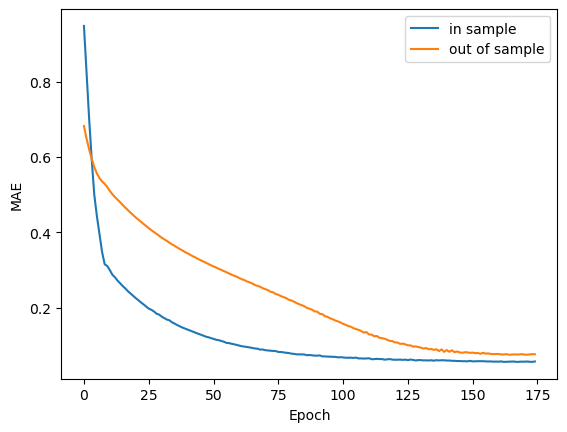

In [119]:
plt.plot(history.history["loss"], label="in sample")
plt.plot(history.history["val_loss"], label="out of sample")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [120]:
coloumns_name = ["a", "b", "rho", "m", "sigma"]

In [121]:
model_y_predictions = pd.DataFrame(model_y_predictions.reshape(-1,5), columns=coloumns_name)
model_y_predictions

,a,b,rho,m,sigma
0,0.000733,0.008034,0.768887,0.047124,0.003317
1,0.001117,0.039449,0.510964,0.075666,0.009300
2,0.000082,1.993116,-0.974303,-0.114452,0.019579
3,0.000068,0.076797,0.439333,0.170553,0.102254
4,0.000072,0.066919,0.014227,0.093259,0.102531
...,...,...,...,...,...
1334,0.001087,0.117192,-0.417604,-0.408200,0.516078
1335,0.040228,0.188307,-0.370368,-0.505156,0.730939
1336,0.253368,0.174922,0.355166,0.201808,0.001276
1337,0.293743,1.998537,0.988332,0.981854,0.059238


In [123]:
y_test = pd.DataFrame(y_test.reshape(-1,5), columns=coloumns_name)
y_test

,a,b,rho,m,sigma
0,7.286113e-04,0.007832,0.776055,0.045606,0.000001
1,1.118448e-03,0.018101,0.520311,0.075564,0.000001
2,1.474238e-03,0.017082,-0.678482,-0.031441,0.000001
3,1.454304e-09,0.056027,0.437614,0.170635,0.101964
4,3.112884e-12,0.067264,0.014524,0.095045,0.101974
...,...,...,...,...,...
1334,4.237714e-11,0.116236,-0.419304,-0.415035,0.517738
1335,3.948757e-02,0.169801,-0.387733,-0.533641,0.725977
1336,2.531792e-01,0.173018,0.354842,0.201397,0.000001
1337,2.945203e-01,2.007008,0.993016,0.983252,0.048985


In [124]:
flat_y_test_indexes = [item for sublist in y_test_indexes for item in sublist]

In [125]:
model_y_predictions['timestamp'] = [idx[0] for idx in flat_y_test_indexes]
model_y_predictions['Time_To_Maturity'] = [idx[1] for idx in flat_y_test_indexes]
model_y_predictions.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
model_y_predictions

a         b       rho         m  \
timestamp           Time_To_Maturity                                           
2024-07-11 17:32:41 0.001405          0.000733  0.008034  0.768887  0.047124   
                    0.004137          0.001117  0.039449  0.510964  0.075666   
                    0.006869          0.000082  1.993116 -0.974303 -0.114452   
                    0.020531          0.000068  0.076797  0.439333  0.170553   
                    0.039656          0.000072  0.066919  0.014227  0.093259   
...                                        ...       ...       ...       ...   
2024-07-11 20:39:30 0.211788          0.001087  0.117192 -0.417604 -0.408200   
                    0.460421          0.040228  0.188307 -0.370368 -0.505156   
                    0.536924          0.253368  0.174922  0.355166  0.201808   
                    0.709055          0.293743  1.998537  0.988332  0.981854   
                    0.957689          0.400635  0.084064  0.641773  0.296274   

                                         sigma  
timestamp           Time_To_Maturity            
2024-07-11 17:32:41 0.001405          0.003317  
                    0.004137          0.009300  
                    0.006869          0.019579  
                    0.020531          0.102254  
                    0.039656          0.102531  
...                                        ...  
2024-07-11 20:39:30 0.211788          0.516078  
                    0.460421          0.730939  
                    0.536924          0.001276  
                    0.709055          0.059238  
                    0.957689          0.003462  

[1339 rows x 5 columns]

In [126]:
y_test['timestamp'] = [idx[0] for idx in flat_y_test_indexes]
y_test['Time_To_Maturity'] = [idx[1] for idx in flat_y_test_indexes]
y_test.set_index(['timestamp', 'Time_To_Maturity'], inplace=True)
y_test

a         b       rho  \
timestamp           Time_To_Maturity                                     
2024-07-11 17:32:41 0.001405          7.286113e-04  0.007832  0.776055   
                    0.004137          1.118448e-03  0.018101  0.520311   
                    0.006869          1.474238e-03  0.017082 -0.678482   
                    0.020531          1.454304e-09  0.056027  0.437614   
                    0.039656          3.112884e-12  0.067264  0.014524   
...                                            ...       ...       ...   
2024-07-11 20:39:30 0.211788          4.237714e-11  0.116236 -0.419304   
                    0.460421          3.948757e-02  0.169801 -0.387733   
                    0.536924          2.531792e-01  0.173018  0.354842   
                    0.709055          2.945203e-01  2.007008  0.993016   
                    0.957689          4.009155e-01  0.078870  0.647930   

                                             m     sigma  
timestamp           Time_To_Maturity                      
2024-07-11 17:32:41 0.001405          0.045606  0.000001  
                    0.004137          0.075564  0.000001  
                    0.006869         -0.031441  0.000001  
                    0.020531          0.170635  0.101964  
                    0.039656          0.095045  0.101974  
...                                        ...       ...  
2024-07-11 20:39:30 0.211788         -0.415035  0.517738  
                    0.460421         -0.533641  0.725977  
                    0.536924          0.201397  0.000001  
                    0.709055          0.983252  0.048985  
                    0.957689          0.290454  0.000001  

[1339 rows x 5 columns]

In [127]:
model_y_predictions = model_y_predictions.join(param_data_moneyness[['moneyness']], how='left')
model_y_predictions

a         b       rho         m  \
timestamp           Time_To_Maturity                                           
2024-07-11 17:32:41 0.001405          0.000733  0.008034  0.768887  0.047124   
                    0.004137          0.001117  0.039449  0.510964  0.075666   
                    0.006869          0.000082  1.993116 -0.974303 -0.114452   
                    0.020531          0.000068  0.076797  0.439333  0.170553   
                    0.039656          0.000072  0.066919  0.014227  0.093259   
...                                        ...       ...       ...       ...   
2024-07-11 20:39:30 0.211788          0.001087  0.117192 -0.417604 -0.408200   
                    0.460421          0.040228  0.188307 -0.370368 -0.505156   
                    0.536924          0.253368  0.174922  0.355166  0.201808   
                    0.709055          0.293743  1.998537  0.988332  0.981854   
                    0.957689          0.400635  0.084064  0.641773  0.296274   

                                         sigma  \
timestamp           Time_To_Maturity             
2024-07-11 17:32:41 0.001405          0.003317   
                    0.004137          0.009300   
                    0.006869          0.019579   
                    0.020531          0.102254   
                    0.039656          0.102531   
...                                        ...   
2024-07-11 20:39:30 0.211788          0.516078   
                    0.460421          0.730939   
                    0.536924          0.001276   
                    0.709055          0.059238   
                    0.957689          0.003462   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-07-11 17:32:41 0.001405          [-0.49339016280525977, -0.35985877018073703, -...  
                    0.004137          [-0.07770320277295548, -0.05901106976080291, -...  
                    0.006869          [-0.0585101438740477, -0.04016100520585111, -0...  
                    0.020531          [-0.48872969686728795, -0.3551983042427654, -0...  
                    0.039656          [-0.5172684710383713, -0.46011005719842274, -0...  
...                                                                                 ...  
2024-07-11 20:39:30 0.211788          [-1.746148072420055, -1.3406829643118907, -1.0...  
                    0.460421          [-1.7684504115839803, -1.3629853034758157, -1....  
                    0.536924          [-1.3713221430896279, -1.0836400706378468, -0....  
                    0.709055          [-1.1025201430491003, -0.8793765917348907, -0....  
                    0.957689          [-1.1205322806079652, -0.8973887292937553, -0....  

[1339 rows x 6 columns]

In [128]:
y_test = y_test.join(param_data_moneyness[['moneyness']], how='left')
y_test

a         b       rho  \
timestamp           Time_To_Maturity                                     
2024-07-11 17:32:41 0.001405          7.286113e-04  0.007832  0.776055   
                    0.004137          1.118448e-03  0.018101  0.520311   
                    0.006869          1.474238e-03  0.017082 -0.678482   
                    0.020531          1.454304e-09  0.056027  0.437614   
                    0.039656          3.112884e-12  0.067264  0.014524   
...                                            ...       ...       ...   
2024-07-11 20:39:30 0.211788          4.237714e-11  0.116236 -0.419304   
                    0.460421          3.948757e-02  0.169801 -0.387733   
                    0.536924          2.531792e-01  0.173018  0.354842   
                    0.709055          2.945203e-01  2.007008  0.993016   
                    0.957689          4.009155e-01  0.078870  0.647930   

                                             m     sigma  \
timestamp           Time_To_Maturity                       
2024-07-11 17:32:41 0.001405          0.045606  0.000001   
                    0.004137          0.075564  0.000001   
                    0.006869         -0.031441  0.000001   
                    0.020531          0.170635  0.101964   
                    0.039656          0.095045  0.101974   
...                                        ...       ...   
2024-07-11 20:39:30 0.211788         -0.415035  0.517738   
                    0.460421         -0.533641  0.725977   
                    0.536924          0.201397  0.000001   
                    0.709055          0.983252  0.048985   
                    0.957689          0.290454  0.000001   

                                                                              moneyness  
timestamp           Time_To_Maturity                                                     
2024-07-11 17:32:41 0.001405          [-0.49339016280525977, -0.35985877018073703, -...  
                    0.004137          [-0.07770320277295548, -0.05901106976080291, -...  
                    0.006869          [-0.0585101438740477, -0.04016100520585111, -0...  
                    0.020531          [-0.48872969686728795, -0.3551983042427654, -0...  
                    0.039656          [-0.5172684710383713, -0.46011005719842274, -0...  
...                                                                                 ...  
2024-07-11 20:39:30 0.211788          [-1.746148072420055, -1.3406829643118907, -1.0...  
                    0.460421          [-1.7684504115839803, -1.3629853034758157, -1....  
                    0.536924          [-1.3713221430896279, -1.0836400706378468, -0....  
                    0.709055          [-1.1025201430491003, -0.8793765917348907, -0....  
                    0.957689          [-1.1205322806079652, -0.8973887292937553, -0....  

[1339 rows x 6 columns]

In [129]:
y_test.xs("2024-07-11 17:32:41", level="timestamp").index[0]

0.0014049924649299

In [131]:
model_y_params = (model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][0], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][1], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][2], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][3], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][4])

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_1936\2251627438.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_y_params = (model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][0], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][1], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][2], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][3], model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][4])


In [132]:
y_test_params = (y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][0], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][1], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][2], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][3], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][4])

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_1936\3742423003.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_params = (y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][0], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][1], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][2], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][3], y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][4])


In [134]:
y_test_params

(0.0925253026712323,
 0.10009701730876,
 -0.3008403816450442,
 0.6730230786580147,
 1.0000000000000006e-06)

In [137]:
model_y_log_money = model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][5]

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_1936\4038986673.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  model_y_log_money = model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][5]


In [138]:
y_test_log_money = y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][5]

C:\Users\Timi Durojaiye\AppData\Local\Temp\ipykernel_1936\1425586050.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_test_log_money = y_test.xs("2024-07-11 17:32:41", level="timestamp").iloc[8][5]


In [139]:
%cd ..

c:\Users\Timi Durojaiye\Desktop\Designing-optimal-options-market-making-systems-utilising-AI-for-implied-volatility-structures


In [140]:
from volatility_modelling.models.svi_model import SVIModel

In [141]:
svi = SVIModel()

In [142]:
model_ivs = np.sqrt(svi.evaluate_svi(params=model_y_params, x=model_y_log_money) / model_y_predictions.xs("2024-07-11 17:32:41", level="timestamp").index[8])

In [143]:
ivs = np.sqrt(svi.evaluate_svi(params=y_test_params, x=y_test_log_money) / y_test.xs("2024-07-11 17:32:41", level="timestamp").index[8])

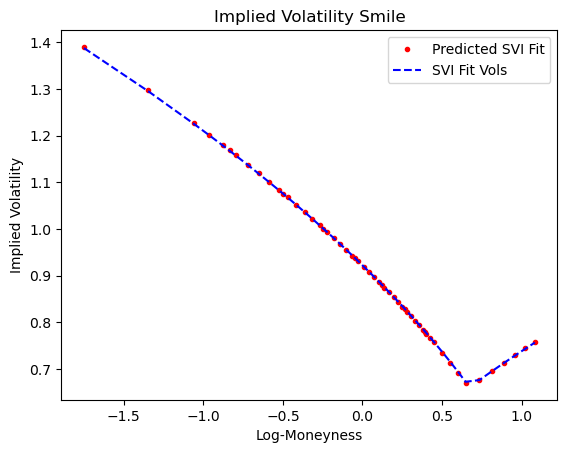

In [152]:
plt.plot(model_y_log_money, model_ivs, 'ro', label='Predicted SVI Fit', markersize=3)
plt.plot(y_test_log_money, ivs, 'b--', label='SVI Fit Vols')
plt.xlabel("Log-Moneyness")
plt.ylabel("Implied Volatility")
plt.title("Implied Volatility Smile")
plt.legend()
plt.show()

In [ ]:
%cd ml_models/